<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/dacon_timeseries/blob/main/neural_prophet_residual_learning_0520.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import os
os.chdir('/content/gdrive/My Drive/dacon_timeseries')

In [3]:
!pip install neuralprophet

     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 748.8MB 23kB/s 
     |████████████████████████████████| 81kB 4.2MB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [4]:
dangjin_fcst= pd.read_csv('dangjin_fcst_data.csv')
dangjin_obs= pd.read_csv('dangjin_obs_data.csv')
energy = pd.read_csv('energy.csv') # 발전소별 발전량
sample_submission = pd.read_csv('sample_submission.csv')
site_info = pd.read_csv('site_info.csv') # 발전소 정보
ulsan_fcst = pd.read_csv('ulsan_fcst_data.csv')
ulsan_obs= pd.read_csv('ulsan_obs_data.csv')

# EDA

In [5]:
import pandas as pd
import numpy as np
from datetime import timedelta
from glob import glob
import plotly.express as px
from neuralprophet import NeuralProphet

## plotly.io를 import 한 후 renderers 기본값을 꼭 "notebook_connected" 로 설정해주시기 바랍니다.
import plotly.io as pio
pio.renderers.default = "notebook_connected"

## Forecast 데이터 전처리

In [6]:
dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast time'])
ulsan_fcst['Forecast_time'] = pd.to_datetime(ulsan_fcst['Forecast time'])

In [7]:
#여기서는 14시 예보만을 사용
dangjin_fcst_14 = dangjin_fcst[dangjin_fcst['Forecast_time'].dt.hour==14]
ulsan_fcst_14 = ulsan_fcst[ulsan_fcst['Forecast_time'].dt.hour==14]
#다음 날의 기상 예보가 필요하여 예보시간 기준 10시간 후(다음날 00:00)부터 33시간 후(23:00) 데이터만 사용
dangjin_fcst_14 = dangjin_fcst_14[(dangjin_fcst_14['forecast']>=10)&(dangjin_fcst_14['forecast']<=33)]
ulsan_fcst_14 = ulsan_fcst_14[(ulsan_fcst_14['forecast']>=10)&(ulsan_fcst_14['forecast']<=33)]

In [8]:
def to_date(x):
    return pd.DateOffset(hours=x)

dangjin_fcst_14['Forecast_time'] = dangjin_fcst_14['Forecast_time'] + dangjin_fcst_14['forecast'].map(to_date)
ulsan_fcst_14['Forecast_time'] = ulsan_fcst_14['Forecast_time'] + ulsan_fcst_14['forecast'].map(to_date)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning:

Adding/subtracting object-dtype array to DatetimeArray not vectorized



In [9]:
dangjin_fcst_14 = dangjin_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
ulsan_fcst_14 = ulsan_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

In [10]:
#1시간 단위 데이터프레임 생성
dangjin_fcst_14_ = pd.DataFrame()
dangjin_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

ulsan_fcst_14_ = pd.DataFrame()
ulsan_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

In [11]:
#3시간 단위인거 1시간 단위로 채우기 (merge, interpolate(선형보간))
dangjin_fcst_14_ = pd.merge(dangjin_fcst_14_, dangjin_fcst_14, on='Forecast_time', how='outer') #NaN 있는 상태의 1시가 간격 df 만들어짐
ulsan_fcst_14_ = pd.merge(ulsan_fcst_14_, ulsan_fcst_14, on='Forecast_time', how='outer')

In [12]:
dangjin_fcst = dangjin_fcst_14_.interpolate()
ulsan_fcst = ulsan_fcst_14_.interpolate()

In [ ]:
#dangjin_fcst['Forecast_time'] = dangjin_fcst['Forecast_time'].astype(str)  #이거 해주면 train_datast에서 astype(int) 해줘야함
#ulsan_fcst['Forecast_time'] = ulsan_fcst['Forecast_time'].astype(str)

In [14]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    
    concat_df['hour'] = concat_df['Forecast_time'].dt.hour#.astype(int)
    concat_df['year'] = concat_df['Forecast_time'].dt.year#.astype(int)
    concat_df['month'] = concat_df['Forecast_time'].dt.month#.astype(int)
    concat_df['day'] = concat_df['Forecast_time'].dt.day#.astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    
    # 마지막 5일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*5]
    val_df = feature_df.iloc[-24*5:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_y = train_df[target]#.to_numpy()
    
    val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

## energy 데이터 전처리
- time : 1시간 단위 계량된 시간  
  (ex-2018-03-01 1:00:00 => 2018-03-01 00:00:00 ~ 2018-03-01 1:00:00 1시간동안 발전량 계량)
- dangjin_floating : 당진수상태양광 발전량(KW)
- dangjin_warehouse : 당진자재창고태양광 발전량(KW)
- dangjin : 당진태양광 발전량(KW)
- ulsan : 울산태양광 발전량(KW)

In [15]:
energy.shape

(25632, 5)

In [16]:
energy # 2018-3-1 ~ 2021-1-31 1시간 단위로 기록된 각 발전소별 발전량 데이터

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-01 1:00:00,0.0,0.0,0,0
1,2018-03-01 2:00:00,0.0,0.0,0,0
2,2018-03-01 3:00:00,0.0,0.0,0,0
3,2018-03-01 4:00:00,0.0,0.0,0,0
4,2018-03-01 5:00:00,0.0,0.0,0,0
...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.0,0.0,0,0
25628,2021-01-31 21:00:00,0.0,0.0,0,0
25629,2021-01-31 22:00:00,0.0,0.0,0,0
25630,2021-01-31 23:00:00,0.0,0.0,0,0


In [17]:
energy['date'] = energy['time'].apply(lambda x: x.split()[0])
energy['time'] = energy['time'].apply(lambda x: x.split()[1])
energy['time'] = energy['time'].str.rjust(8,'0') # 한자릿수 시간 앞에 0 추가 ex) 3시 -> 03시

In [18]:
from datetime import timedelta

# 24시를 00시로 바꿔주기
energy.loc[energy['time']=='24:00:00','time'] = '00:00:00'
energy['time'] = energy['date'] + ' ' + energy['time']
energy['time'] = pd.to_datetime(energy['time'])
energy.loc[energy['time'].dt.hour==0,'time'] += timedelta(days=1)
energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan,date
0,2018-03-01 01:00:00,0.0,0.0,0,0,2018-03-01
1,2018-03-01 02:00:00,0.0,0.0,0,0,2018-03-01
2,2018-03-01 03:00:00,0.0,0.0,0,0,2018-03-01
3,2018-03-01 04:00:00,0.0,0.0,0,0,2018-03-01
4,2018-03-01 05:00:00,0.0,0.0,0,0,2018-03-01
...,...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.0,0.0,0,0,2021-01-31
25628,2021-01-31 21:00:00,0.0,0.0,0,0,2021-01-31
25629,2021-01-31 22:00:00,0.0,0.0,0,0,2021-01-31
25630,2021-01-31 23:00:00,0.0,0.0,0,0,2021-01-31


- 데이터의 row는 25632개가 있어 약 일주일 정도의 에너지 발전량을 시각화해보자.
- 용량이 큰 당진이 대체로 많이 발전하고, 
- 용량이 적은 울산이 대체로 적게 발전
- 3월 4일 경에는 모든 발전소의 발전량이 낮은데 아무래도 날씨의 영향인 것 같다.

In [19]:
# time column을 분해하여 의미있을 것 같은 month와 hour로 시각화해보자.
energy['month'] = energy['time'].dt.month
energy['hour'] = energy['time'].dt.hour

# NeuralProphet
* Energy 값만 사용하는 방식

In [20]:
def sola_nmae(answer, pred, cap):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= cap
    
    target_idx = np.where(answer>=cap*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [21]:
train_en = energy[:-24*30] #21년 1월 1일까지 24912 rows
test_en = energy[-24*30:] #21년 1월 2일 ~ 1월 31일

In [22]:
# validation, 시각화를 위한 함수
def make_val(colo, cap, train_df): 
  column = colo
  df = pd.DataFrame()
  df['ds'] = train_df['time']
  df['y'] = train_df[column]
  df.y = df.y.fillna(0)
  train = df[:-24*30] #21년 12월 2일까지   #24*30이 24시간 *30일 이네
  val = df[-24*30:] #21년 12월 3일 ~ 1월 1일

# Neural Prophet 설명 - http://insightcampus.co.kr:9090/insightcommunity/?mod=document&uid=12964

  model = NeuralProphet(yearly_seasonality=True, daily_seasonality=True)
  loss = model.fit(train, freq="H")
  df_pred = model.make_future_dataframe(train, periods=24*30)  #train 데이터 이후로 periods만큼 예측
  predict = model.predict(df_pred)

  #visualization
  plt.figure(figsize=(20,5))
  plt.plot(np.maximum(0,predict['yhat1'].values), label='pred')
  plt.plot(val.y.values, label='Actual') 
  plt.legend()
  print('CV Score : ', sola_nmae(val.y.values, np.maximum(0,predict['yhat1'].values), cap))
  plt.show()

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s, SmoothL1Loss=0.016, MAE=70.2, RegLoss=0]


CV Score :  9.306993695940289


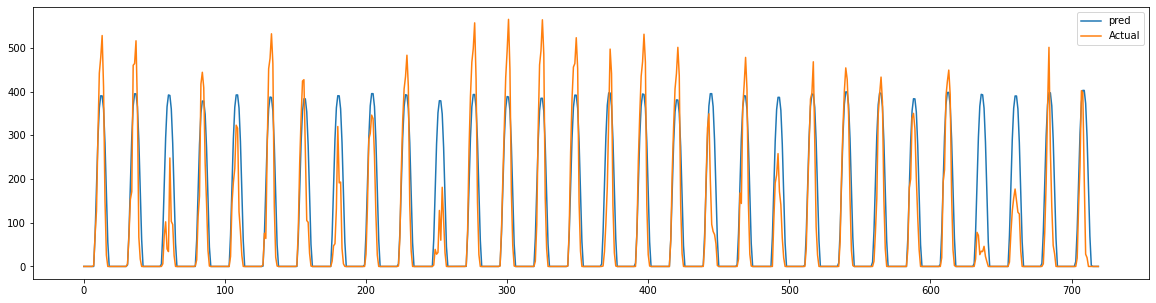

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s, SmoothL1Loss=0.0158, MAE=53.2, RegLoss=0]


CV Score :  12.167631882887619


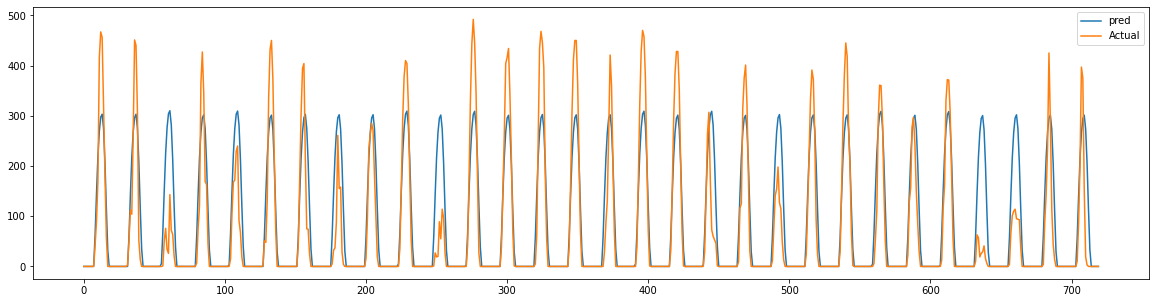

In [25]:
make_val('dangjin_floating', 1000, train_en)
make_val('dangjin_warehouse', 700, train_en)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s, SmoothL1Loss=0.0158, MAE=81.2, RegLoss=0]


CV Score :  14.036870522932574


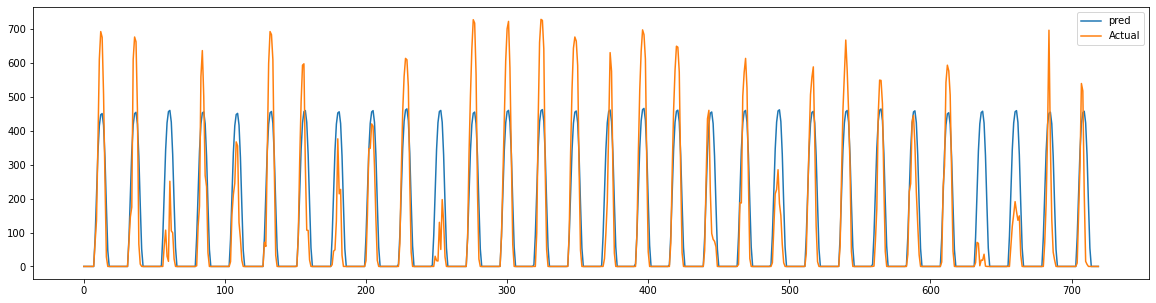

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s, SmoothL1Loss=0.0165, MAE=37.3, RegLoss=0]


CV Score :  9.157136879504566


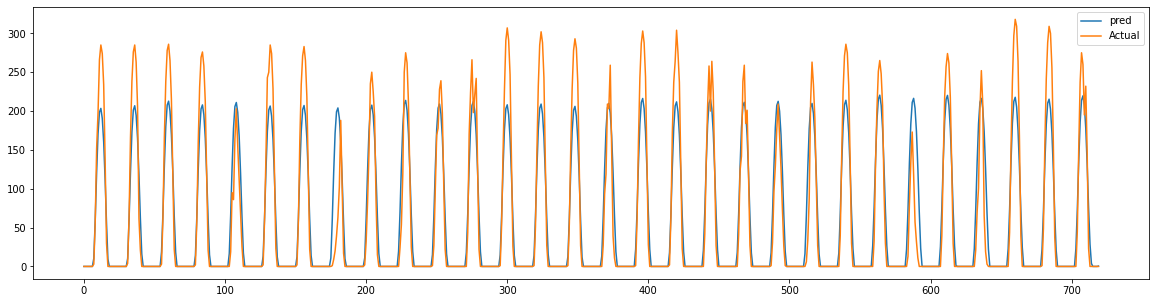

In [26]:
make_val('dangjin', 1000, train_en)
make_val('ulsan', 500, train_en)

* 전반적으로 예측을 다 똑같이 하고있음을 알 수 있다..
* 0 값을 조절(relu 적용)했더니 에러가 더 높아진 경우도 있음... 흠... 근데 오차범위인듯 ㅇㅇ

In [27]:
def train_np(colo, cap, train_df):
  column = colo
  df = pd.DataFrame()
  df['ds'] = train_df['time']
  df['y'] = train_df[column]
  df.y = df.y.fillna(0)

  model = NeuralProphet(yearly_seasonality=True, daily_seasonality=True)
  loss = model.fit(df, freq="H")

  #predict
  df_pred = model.make_future_dataframe(df, periods=9000)
  predict = model.predict(df_pred)

  return predict

In [29]:
flt_pred = train_np('dangjin_floating', 1000, train_en)
ware_pred = train_np('dangjin_warehouse', 700, train_en)
d_pred = train_np('dangjin', 1000, train_en)
u_pred = train_np('ulsan', 500, train_en)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s, SmoothL1Loss=0.0169, MAE=72.2, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s, SmoothL1Loss=0.0156, MAE=52.4, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s, SmoothL1Loss=0.0157, MAE=79.9, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s, SmoothL1Loss=0.0165, MAE=37.3, RegLoss=0]


In [132]:
flt_pred #val 안뺐을때는 2월 1일부터였음

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,season_daily
0,2021-01-02 01:00:00,None,-31.988287,None,121.176163,-38.430298,5.630266,-120.364410
1,2021-01-02 02:00:00,None,-39.707630,None,121.177322,-38.437912,5.633713,-128.080765
2,2021-01-02 03:00:00,None,-43.819313,None,121.178482,-38.445534,5.594486,-132.146744
3,2021-01-02 04:00:00,None,-35.454113,None,121.179657,-38.453175,5.510887,-123.691483
4,2021-01-02 05:00:00,None,-27.890915,None,121.180817,-38.460838,5.381597,-115.992493
...,...,...,...,...,...,...,...,...
8995,2022-01-11 20:00:00,None,-28.301027,None,131.646118,-39.759727,3.105656,-123.293091
8996,2022-01-11 21:00:00,None,-29.894577,None,131.647293,-39.759762,2.918420,-124.700531
8997,2022-01-11 22:00:00,None,-32.931667,None,131.648468,-39.759705,2.736166,-127.556602
8998,2022-01-11 23:00:00,None,-33.806068,None,131.649612,-39.759579,2.560634,-128.256744


In [ ]:
test_en

## 원래 submission (residual learning에서 실행 X)

In [ ]:
def sub(predict, col, file):
  # 2021-02-01 ~ 2021-03-01
  predict_1 = predict.copy()
  predict_1 = predict_1.query('ds >= "2021-02-01 00:00:00"')
  predict_1 = predict_1.query('ds <= "2021-03-01 00:00:00"') #submission 파일에는28일 24시로 되어있음
  #print(predict_1)
  # 2021-06-09 ~ 2021-07-09
  predict_2 = predict.copy()
  predict_2 = predict_2.query('ds > "2021-06-09 00:00:00"')
  predict_2 = predict_2.query('ds <= "2021-07-09 00:00:00"')
  #print(predict_2)
  file[col] = list(predict_1['yhat1']) + list(predict_2['yhat1'])
  
  return file


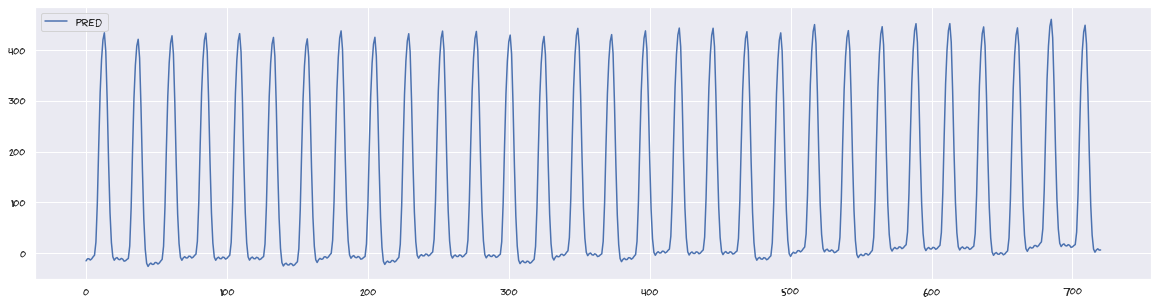

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(flt_pred.loc[:720,'yhat1'].values, label='pred')
plt.legend()
plt.show()

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
sub_file = sub(flt_pred, 'dangjin_floating', submission)
sub_file = sub(ware_pred, 'dangjin_warehouse', sub_file)
sub_file = sub(d_pred, 'dangjin', sub_file)
sub_file = sub(u_pred, 'ulsan', sub_file)

In [ ]:
sub_file

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,-14.677555,-16.536736,-28.426849,0.905134
1,2021-02-01 02:00:00,-10.594124,-17.916872,-24.527168,0.275442
2,2021-02-01 03:00:00,-10.485455,-21.479921,-22.799957,0.220984
3,2021-02-01 04:00:00,-12.994946,-21.028902,-23.793522,2.686935
4,2021-02-01 05:00:00,-10.701351,-17.424858,-24.130058,3.267330
...,...,...,...,...,...
1387,2021-07-08 20:00:00,5.154404,-6.259411,7.490631,-2.662952
1388,2021-07-08 21:00:00,-1.268787,-4.270252,5.347076,-0.501461
1389,2021-07-08 22:00:00,2.849529,-2.978516,5.574989,-2.286572
1390,2021-07-08 23:00:00,4.757988,-4.316895,3.530472,-4.406937


In [ ]:
#sub_file.to_csv('neural_prophet_submission0512.csv', index =False)

* Prediction 그대로 냈을때 점수 13.66631 (109등 ;;)


# Residual energy파일

In [32]:
def sub_res(predict, col, file): #predict해서 residual을 위한 구간만 추출하는 함수
  # 2021-02-01 ~ 2021-03-01
  predict_1 = predict.copy()
  predict_1 = predict_1.query('ds >= "2021-01-02 01:00:00"')
  predict_1 = predict_1.query('ds <= "2021-02-01 00:00:00"') #submission 파일에는28일 24시로 되어있음
  
  file[col] = list(predict_1['yhat1']) 
  
  return file

In [40]:
pred4res = pd.DataFrame() #residual learning을 위한 np prediction 데이터

In [41]:
pred4res['time']=test_en['time']

pred4res = sub_res(flt_pred, 'dangjin_floating', pred4res)
pred4res = sub_res(ware_pred, 'dangjin_warehouse', pred4res)
pred4res = sub_res(d_pred, 'dangjin', pred4res)
pred4res = sub_res(u_pred, 'ulsan', pred4res)

In [42]:
pred4res  #np prediction(1월 2일 ~) 에서 residual learning에 사용할 구간 가져오기

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
24912,2021-01-02 01:00:00,-31.988287,-26.812878,-26.894615,2.684761
24913,2021-01-02 02:00:00,-39.707630,-27.734667,-27.269020,2.953831
24914,2021-01-02 03:00:00,-43.819313,-29.788418,-32.008839,3.986061
24915,2021-01-02 04:00:00,-35.454113,-29.623903,-29.332199,5.563370
24916,2021-01-02 05:00:00,-27.890915,-26.803877,-24.044472,4.562126
...,...,...,...,...,...
25627,2021-01-31 20:00:00,-36.838951,-27.491056,-17.712837,19.969864
25628,2021-01-31 21:00:00,-37.903896,-26.292780,-9.439342,22.276489
25629,2021-01-31 22:00:00,-40.364563,-22.765747,-5.307095,22.969681
25630,2021-01-31 23:00:00,-40.619385,-23.134533,-11.196896,21.811859


In [130]:
neural_prophet_pred = pd.read_csv('neural_prophet_submission0512.csv')  #neural prophet에서 예측한 값 (2/1 ~)

In [45]:
test_en.iloc[:,1:5]  #test energy

,dangjin_floating,dangjin_warehouse,dangjin,ulsan
24912,0.0,0.0,0,0
24913,0.0,0.0,0,0
24914,0.0,0.0,0,0
24915,0.0,0.0,0,0
24916,0.0,0.0,0,0
...,...,...,...,...
25627,0.0,0.0,0,0
25628,0.0,0.0,0,0
25629,0.0,0.0,0,0
25630,0.0,0.0,0,0


In [47]:
# 원래 값 - 예측 값 해서 residual을 구하기!
residual= test_en.iloc[:,1:5]-pred4res.iloc[:,1:]

In [48]:
residual

,dangjin_floating,dangjin_warehouse,dangjin,ulsan
24912,31.988287,26.812878,26.894615,-2.684761
24913,39.707630,27.734667,27.269020,-2.953831
24914,43.819313,29.788418,32.008839,-3.986061
24915,35.454113,29.623903,29.332199,-5.563370
24916,27.890915,26.803877,24.044472,-4.562126
...,...,...,...,...
25627,36.838951,27.491056,17.712837,-19.969864
25628,37.903896,26.292780,9.439342,-22.276489
25629,40.364563,22.765747,5.307095,-22.969681
25630,40.619385,23.134533,11.196896,-21.811859


# Residual Learning
진행 방향 ⇒ residual을 예측하는 부스팅계열 모델 만들기(날씨데이터 반영) 그리고 test에 대해 예측한 residual을 neural prophet 예측값에다가 더해주기.

neural prophet으로 예측 못한 부분을 부스팅 모델로 예측 해준다는 식.

In [49]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

In [58]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [50]:
def residual_term(df):
  df = df.query('Forecast_time >= "2021-01-02 01:00:00"')
  df = df.query('Forecast_time <= "2021-02-01 00:00:00"')
  return df

In [53]:
dangjin_fcst_r=residual_term(dangjin_fcst) #예보 데이터를 residual learning을 위한 구간으로 자름 (1월2일 ~ 2월 1일)

In [76]:
ulsan_fcst_r=residual_term(ulsan_fcst)

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [56]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

### 당진수상태양광 예측 모델 학습

In [59]:
residual

,dangjin_floating,dangjin_warehouse,dangjin,ulsan
24912,31.988287,26.812878,26.894615,-2.684761
24913,39.707630,27.734667,27.269020,-2.953831
24914,43.819313,29.788418,32.008839,-3.986061
24915,35.454113,29.623903,29.332199,-5.563370
24916,27.890915,26.803877,24.044472,-4.562126
...,...,...,...,...
25627,36.838951,27.491056,17.712837,-19.969864
25628,37.903896,26.292780,9.439342,-22.276489
25629,40.364563,22.765747,5.307095,-22.969681
25630,40.619385,23.134533,11.196896,-21.811859


In [87]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608] #25608-1에서 25608로 고치니까 val_x 끝까지 나옴 !
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    
    concat_df['hour'] = concat_df['Forecast_time'].dt.hour#.astype(int)
    concat_df['year'] = concat_df['Forecast_time'].dt.year#.astype(int)
    concat_df['month'] = concat_df['Forecast_time'].dt.month#.astype(int)
    concat_df['day'] = concat_df['Forecast_time'].dt.day#.astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    
    # 마지막 5일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*5]
    val_df = feature_df.iloc[-24*5:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_y = train_df[target]#.to_numpy()
    
    val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

In [134]:
train_x, train_y, val_x, val_y = train_datast(residual, dangjin_fcst_r, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000

In [ ]:
# train_datast에서 to_numpy 빼고 df로 출력할때
#val_x #왜 719행 (2월 1일 00시)이 비어있지..?

In [ ]:
# 맨 마지막행 (index 719)가 알 수 없는 이유로 비어있어서 값 채워줌
#6.000000	80.000000	5.600000	177.000000	4.0
'''
val_x.year.fillna(2021.0, inplace=True)
val_x.month.fillna(2.0, inplace=True)
val_x.day.fillna(1.0, inplace=True)
val_x.hour.fillna(0.0, inplace=True)
val_x.Temperature.fillna(6.0, inplace=True)
val_x.Humidity.fillna(80.0, inplace=True)
val_x.WindSpeed.fillna(5.600000, inplace=True)
val_x.WindDirection.fillna(177.000000, inplace=True)
val_x.Cloud.fillna(4.0, inplace=True)
'''

In [ ]:
#val_y

In [62]:
#train datast 함수에서 to_numpy()해서 np array로 출력할때
#val_x[-1] = [2021.0, 2.0,1.0,0.0,6.0,80.0,5.60,177.0,4.0]

In [135]:
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=1000) #에러 나는이유: 인덱스 안맞아서였음 ! 어떤건 600부터 어떤건 0부터....

Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's l1: 65.3498	valid_0's score: 16.8524
[1000]	valid_0's l1: 68.8901	valid_0's score: 17.44
Early stopping, best iteration is:
[69]	valid_0's l1: 55.5864	valid_0's score: 16.7605


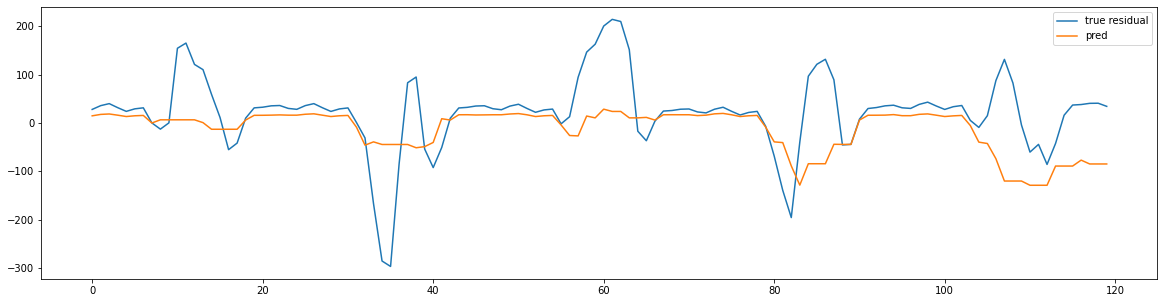

CV Score :  16.76052938858148


In [136]:
pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true residual')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

예측 왜이렇게 못함?????

* xgboost

In [93]:
import xgboost

xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model.fit(train_x,train_y)
xg_pred = xgb_model.predict(val_x)

[04:03:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


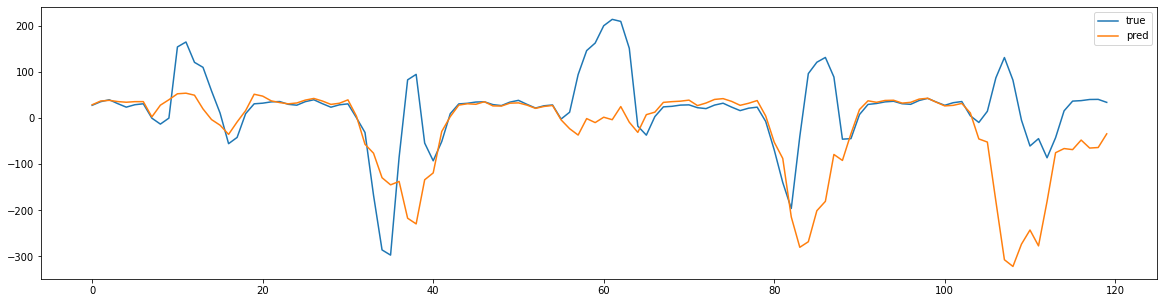

CV Score :  19.441890269976398


In [94]:
plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(xg_pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, xg_pred))

* 둘다 예측 무슨일....?

### 당진자재창고태양광 예측 모델 학습

In [95]:
train_x, train_y, val_x, val_y = train_datast(residual, dangjin_fcst_r, target='dangjin_warehouse')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 700
dangjin_warehouse_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=10000)

Training until validation scores don't improve for 10000 rounds.
[500]	valid_0's l1: 45.6046	valid_0's score: 15.5186
[1000]	valid_0's l1: 46.2212	valid_0's score: 15.7175
[1500]	valid_0's l1: 46.4427	valid_0's score: 15.9522
[2000]	valid_0's l1: 47.0653	valid_0's score: 16.1668
[2500]	valid_0's l1: 47.2612	valid_0's score: 16.3626
[3000]	valid_0's l1: 47.4948	valid_0's score: 16.5992
[3500]	valid_0's l1: 47.6049	valid_0's score: 16.7937
[4000]	valid_0's l1: 47.6096	valid_0's score: 16.9068
[4500]	valid_0's l1: 47.7267	valid_0's score: 17.0162
[5000]	valid_0's l1: 47.7345	valid_0's score: 17.1028
[5500]	valid_0's l1: 47.6964	valid_0's score: 17.1563
[6000]	valid_0's l1: 47.6682	valid_0's score: 17.2122
[6500]	valid_0's l1: 47.5953	valid_0's score: 17.255
[7000]	valid_0's l1: 47.5731	valid_0's score: 17.3039
[7500]	valid_0's l1: 47.5778	valid_0's score: 17.3464
[8000]	valid_0's l1: 47.535	valid_0's score: 17.363
[8500]	valid_0's l1: 47.5094	valid_0's score: 17.3812
[9000]	valid_0's l1: 

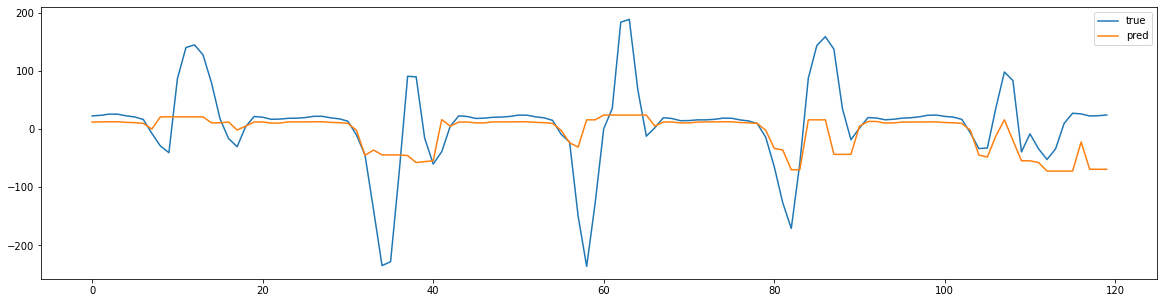

CV Score :  17.164441606079343


In [96]:
pred = dangjin_warehouse_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

Ground Truth 값이 너무 예측 불가한건가....?

### 당진태양광 예측 모델 학습

In [97]:
train_x, train_y, val_x, val_y = train_datast(residual, dangjin_fcst_r, target='dangjin')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=5000)

Training until validation scores don't improve for 5000 rounds.
[500]	valid_0's l1: 65.7953	valid_0's score: 18.9694
[1000]	valid_0's l1: 69.6439	valid_0's score: 20.427
[1500]	valid_0's l1: 70.0443	valid_0's score: 20.5366
[2000]	valid_0's l1: 70.4714	valid_0's score: 20.677
[2500]	valid_0's l1: 70.5335	valid_0's score: 20.7514
[3000]	valid_0's l1: 70.5058	valid_0's score: 20.9146
[3500]	valid_0's l1: 70.5984	valid_0's score: 21.0404
[4000]	valid_0's l1: 70.6152	valid_0's score: 21.2074
[4500]	valid_0's l1: 70.5028	valid_0's score: 21.3032
[5000]	valid_0's l1: 70.5472	valid_0's score: 21.4188
Early stopping, best iteration is:
[86]	valid_0's l1: 54.2004	valid_0's score: 18.5151


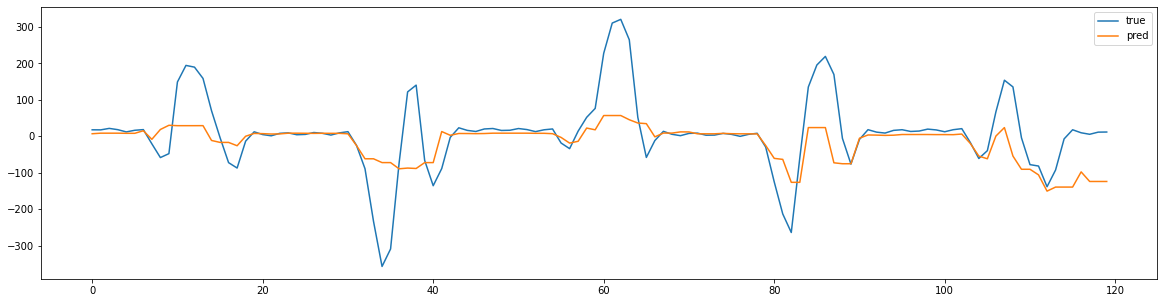

CV Score :  18.515125491651474


In [99]:
pred = dangjin_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

모든 모델 다 전반적으로 급격한 변화는 예측 못하는중

### 울산태양광 예측 모델 학습

In [100]:
train_x, train_y, val_x, val_y = train_datast(residual, ulsan_fcst_r, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=10000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



Training until validation scores don't improve for 10000 rounds.
[500]	valid_0's l1: 45.6683	valid_0's score: nan
[1000]	valid_0's l1: 45.7433	valid_0's score: nan
[1500]	valid_0's l1: 45.8274	valid_0's score: nan
[2000]	valid_0's l1: 45.5257	valid_0's score: nan
[2500]	valid_0's l1: 45.5097	valid_0's score: nan
[3000]	valid_0's l1: 45.4888	valid_0's score: nan
[3500]	valid_0's l1: 45.4876	valid_0's score: nan
[4000]	valid_0's l1: 45.4781	valid_0's score: nan
[4500]	valid_0's l1: 45.4979	valid_0's score: nan
[5000]	valid_0's l1: 45.3995	valid_0's score: nan
[5500]	valid_0's l1: 45.384	valid_0's score: nan
[6000]	valid_0's l1: 45.3942	valid_0's score: nan
[6500]	valid_0's l1: 45.352	valid_0's score: nan
[7000]	valid_0's l1: 45.3291	valid_0's score: nan
[7500]	valid_0's l1: 45.3096	valid_0's score: nan
[8000]	valid_0's l1: 45.2879	valid_0's score: nan
[8500]	valid_0's l1: 45.2724	valid_0's score: nan
[9000]	valid_0's l1: 45.2708	valid_0's score: nan
[9500]	valid_0's l1: 45.2667	valid_0's

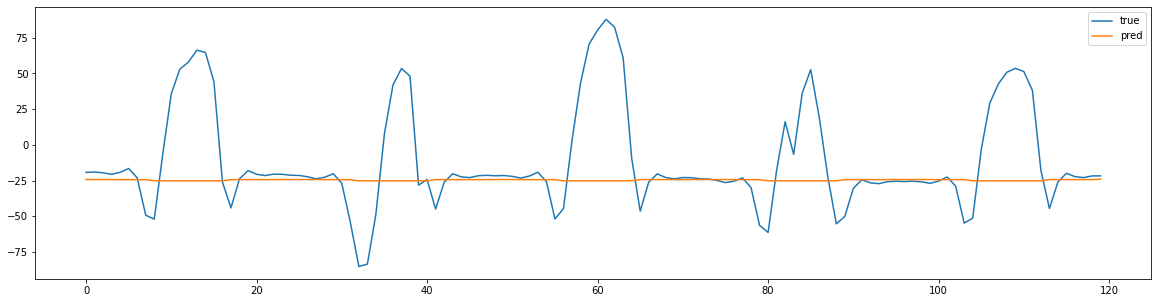

CV Score :  17.682835410779994


In [79]:
pred = ulsan_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

예측이 왜 전혀 안되지.....? 1 round만 하고 끝남

## 테스트 데이터 전처리

In [101]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    
    test_x = test_df#.to_numpy()
    
    return test_x

In [102]:
dangjin_fcst['Forecast_time'] = dangjin_fcst['Forecast_time'].astype(str)
ulsan_fcst['Forecast_time'] = ulsan_fcst['Forecast_time'].astype(str)

In [103]:
dangjin_test = test_datast(dangjin_fcst)
ulsan_test = test_datast(ulsan_fcst)

# private test 구간 예측(2월)
* 각 발전소 발전량 residual 추론
* lgb 모델을 통해 2월 전체 구간 예측

In [104]:
dangjin_test.shape

(672, 9)

In [105]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

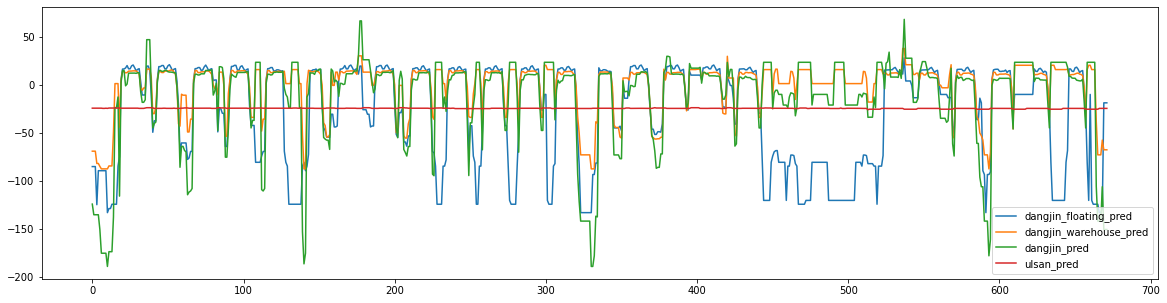

In [106]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

## 제출

In [107]:
neural_prophet_pred = pd.read_csv('neural_prophet_submission0512.csv')

In [108]:
submission = pd.read_csv('sample_submission.csv')

In [109]:
dangjin_floating_pred.shape

(672,)

In [112]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred

submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = 0 #ulsan_pred #ulsan은 왜때문인지 예측이 안돼서 그냥 0으로 채움 (neural prophet 그대로인것)

In [121]:
neural_prophet_pred.iloc[:24*28, 1:5]

,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,-14.677555,-16.536736,-28.426849,0.905134
1,-10.594124,-17.916872,-24.527168,0.275442
2,-10.485455,-21.479921,-22.799957,0.220984
3,-12.994946,-21.028902,-23.793522,2.686935
4,-10.701351,-17.424858,-24.130058,3.267330
...,...,...,...,...
667,9.373535,-9.670856,13.056694,9.023510
668,4.074512,-7.735554,11.300598,11.481537
669,9.306107,-6.539345,11.884155,9.987617
670,12.306854,-8.013561,10.161316,8.148678


In [122]:
submission.iloc[:24*28, 1:5]=submission.iloc[:24*28, 1:5]+neural_prophet_pred.iloc[:24*28, 1:5]

In [123]:
submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,-114.413095,-102.081856,-181.065266,0.905134
1,2021-02-01 02:00:00,-106.246232,-104.842129,-184.359562,0.275442
2,2021-02-01 03:00:00,-106.028894,-111.968228,-180.905140,0.220984
3,2021-02-01 04:00:00,-150.807818,-123.889652,-182.892269,2.686935
4,2021-02-01 05:00:00,-110.766930,-116.681564,-183.565342,3.267330
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


In [126]:
submission.to_csv('residual_learning.csv', index=False)

In [140]:
lgb_947=pd.read_csv('xgboost_9.47.csv')

In [142]:
lgb_947['dangjin_floating']

0       6.667832
1       6.610213
2       6.610213
3       6.610213
4       6.610213
          ...   
1387    0.000000
1388    0.000000
1389    0.000000
1390    0.000000
1391    0.000000
Name: dangjin_floating, Length: 1392, dtype: float64

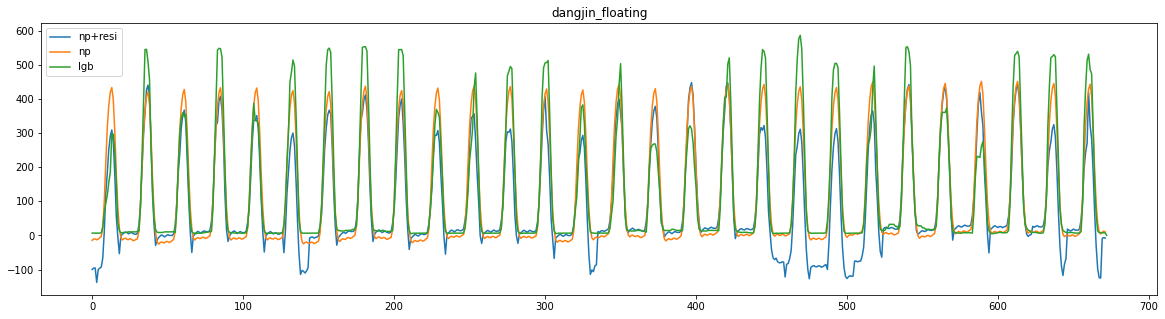

In [145]:
#LGBM 9.47 score랑 같이 찍어본 dangjin_floating
plt.figure(figsize=(20,5))
plt.title('dangjin_floating')
plt.plot(dangjin_floating_pred + neural_prophet_pred.iloc[:24*28, 1] , label = 'np+resi')
plt.plot(neural_prophet_pred.iloc[:24*28, 1], label = 'np') #gt를 못찾겠네 ;
plt.plot(lgb_947.loc[:24*28,'dangjin_floating'], label = 'lgb')
plt.legend()
plt.show()

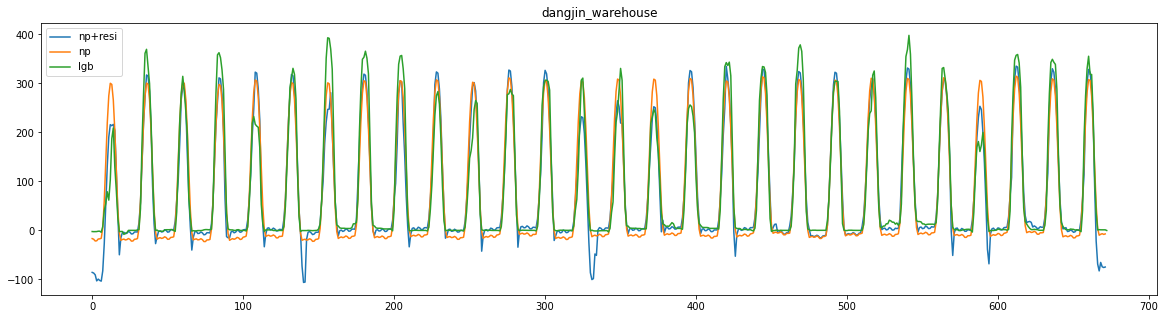

In [146]:
#dangjin_warehouse plot
plt.figure(figsize=(20,5))
plt.title('dangjin_warehouse')
plt.plot(dangjin_warehouse_pred + neural_prophet_pred.iloc[:24*28, 2] , label = 'np+resi')
plt.plot(neural_prophet_pred.iloc[:24*28, 2], label = 'np') #gt를 못찾겠네 ;
plt.plot(lgb_947.loc[:24*28,'dangjin_warehouse'], label = 'lgb')
plt.legend()
plt.show()